In [1]:
#!/usr/bin/env python

# core_evaluation.ipynb

In [2]:
'''
This program reads in core characteristics that were generated by the following programs:

- u/home/prein/papers/2023_Conv-Cores/programs/draft_evaluation/core-properties-from-nc.py
- u/home/prein/papers/2023_Conv-Cores/programs/rwp_evaluation/rwp_core_evaluation.ipynb

The program creates visualizations that compare simulated with observed core characteristics

Author: Andreas F Prein
email:  prein@ucar.edu
date:   Dec. 8th, 2023

'''

'\nThis program reads in core characteristics that were generated by the following programs:\n\n- u/home/prein/papers/2023_Conv-Cores/programs/draft_evaluation/core-properties-from-nc.py\n- u/home/prein/papers/2023_Conv-Cores/programs/rwp_evaluation/rwp_core_evaluation.ipynb\n\nThe program creates visualizations that compare simulated with observed core characteristics\n\nAuthor: Andreas F Prein\nemail:  prein@ucar.edu\ndate:   Dec. 8th, 2023\n\n'

In [3]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# from mpl_toolkits import basemap
# import ESMF
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
# import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys 
import matplotlib.gridspec as gridspec
import seaborn
# from mpl_toolkits.basemap import Basemap, cm
import wrf

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

### User input sectionsi

In [4]:
DX_all = ['4KM','2KM','1KM','500M','250M','125M','obs']
colors = ['#1f78b4','#a6cee3','#33a02c','#ff7f00','#fb9a99','#e31a1c','k']
color_cortype = ['#e41a1c', '#377eb8', '#33a02c']
dx_km = [4,2,1,0.5,0.25,0.125]
DT_all = [16,8,4,2,1,0.5]
dx_m_all = [4000,2000,1000,500,250,125] 

skip_ml = '_ml-scip' # ['', '_ml-scip'] if yes --> 1 km arround the ML will be set to zero

sim_core_dir = '/glade/campaign/mmm/c3we/prein/Papers/2023_Conv-Cores/data/core_stats'+skip_ml+'_20dBZ/'
obs_core_dir = '/glade/campaign/mmm/c3we/prein/Papers/2023_Conv-Cores/data/core_stats_rwp/'

statistics = ['mean elevation', 'mean depth', 'max depth', 'mean speed', 'max speed', 'mean width', 'max width', 'slope from vertical']
up_down = ['up', 'down']
speed = ['1.5','3.0','6.0','10.0']
core_type = ['vp', '2d', '3d']
location = ['sgp', 'mao']
locations = ['loc-'+str(ii).zfill(2) for ii in range(20)]
percentiles = [0,1,5,10,25,50,75,90,95,99,100]


### Read in Observed Core Statistics

In [5]:
files = np.sort(glob.glob(obs_core_dir+'*125m.pkl'))

sgp_stats = {}
mao_stats = {}

for fi in tqdm(range(len(files))):
    file = open(files[fi],'rb')
    object_file = pickle.load(file)
    file.close()
    for di in range(len(up_down)):
        for st in range(len(statistics)):
            for th in speed:
                entry_name = up_down[di]+'_'+statistics[st]+'_'+th
                cores_vp = object_file['cores_vp_'+up_down[di]+'_obs']
                stat = statistics[st]
                # cores_vp = cores_vp_down_obs

                mean_width_rwp = [
                                    [
                                        cores_vp[ii][jj][stat]
                                        for jj in cores_vp[ii].keys()
                                    ]
                                    for ii in [s for s in list(cores_vp.keys()) if th in s]
                                ]
                mean_width_rwp = list([x  for sublist in mean_width_rwp for x in sublist])
                if files[fi].split('/')[-1][:3] == 'mao':
                    try:
                        mao_stats[entry_name] = mao_stats[entry_name] + mean_width_rwp
                    except:
                        mao_stats[entry_name] = mean_width_rwp
                else:
                    try:
                        sgp_stats[entry_name] = sgp_stats[entry_name] + mean_width_rwp
                    except:
                        sgp_stats[entry_name] = mean_width_rwp


100%|██████████| 81/81 [00:01<00:00, 45.11it/s]


### Read in modeled core statistics

In [6]:
mao_stats_vp = {}
sgp_stats_vp = {}

file_sim = np.sort(glob.glob(sim_core_dir+'*/*.pkl'))
for fi in tqdm(range(len(file_sim))):
    loc_act = file_sim[fi].split('/')[-1][:3]
    dx_act = file_sim[fi].split('/')[-1].split('_')[-1][:-4]

    file = open(file_sim[fi],'rb')
    object_file = pickle.load(file)
    file.close()
    for di in range(len(up_down)):
        for co in range(len(core_type)):
            stat_1 = 'cores_'+core_type[co]+'_'+up_down[di]
            for st in range(len(statistics)):
                for th in speed:
                    keys_act = np.array(list(object_file[stat_1].keys()))
                    sel_keys = [th in keys_act[ii] for ii in range(len(keys_act))]
                    for ky in range(sum(sel_keys)):
                        cores_vp = object_file[stat_1][keys_act[sel_keys][ky]]
                        if (core_type[co] == '3d') & (statistics[st] == 'slope from vertical'):
                            continue
                        data_act = [
                                    cores_vp[ii][statistics[st]] for ii in list(cores_vp.keys())
                                    ]
                        if len(data_act) > 0:
                            if type(data_act[0]) == list:
                                data_act = list([x  for sublist in data_act for x in sublist])

                        # data_act = list(data_act)
                        if len(data_act) == 0:
                            continue
                        entry_name = core_type[co]+'_'+up_down[di]+'_'+statistics[st]+'_'+th+'_'+dx_act
                        if loc_act == 'mao':
                            try:
                                mao_stats_vp[entry_name] = mao_stats_vp[entry_name] + data_act
                            except:
                                mao_stats_vp[entry_name] = data_act
                        else:
                            try:
                                sgp_stats_vp[entry_name] = sgp_stats_vp[entry_name] + data_act
                            except:
                                sgp_stats_vp[entry_name] = data_act

100%|██████████| 102/102 [00:37<00:00,  2.75it/s]


### Calculate statistics

In [7]:
core_stats = np.zeros((len(DX_all), len(up_down), len(core_type), len(speed), 
                       len(statistics), len(location), 101)); core_stats[:] = np.nan

for dx in tqdm(range(len(DX_all))):
    for di in range(len(up_down)):
        for ty in range(len(core_type)):
            for sp in range(len(speed)):
                for st in range(len(statistics)):
                    for lo in range(len(location)):
                        direction = up_down[di]
                        dx_act = DX_all[dx]
                        stat = statistics[st]
                        speed_foc = speed[sp]
                        co_type = core_type[ty]

                        if dx < len(DX_all)-1: # loop over simulations
                            try:
                                if location[lo] == 'sgp':
                                    sim_stat = sgp_stats_vp[co_type+'_'+direction+'_'+stat+'_'+speed_foc+'_'+dx_act]
                                else:
                                    sim_stat = mao_stats_vp[co_type+'_'+direction+'_'+stat+'_'+speed_foc+'_'+dx_act]
                                if len(sim_stat) > 0:
                                    if type(sim_stat[0]) == np.ndarray:
                                        sim_stat = list([x  for sublist in sim_stat for x in sublist])
                            except:
                                continue
                            core_stats[dx,di,ty,sp,st,lo,:] = np.percentile(sim_stat,range(101))
                        else:
                            try:
                                if location[lo] == 'sgp':
                                    sim_stat = sgp_stats[direction+'_'+stat+'_'+speed_foc]
                                else:
                                    sim_stat = mao_stats[direction+'_'+stat+'_'+speed_foc]
                                if len(sim_stat) > 0:
                                    if type(sim_stat[0]) == np.ndarray:
                                        sim_stat = list([x  for sublist in sim_stat for x in sublist])
                            except:
                                continue
                            core_stats[dx,di,ty,sp,st,lo,:] = np.nanpercentile(sim_stat,range(101))


100%|██████████| 7/7 [01:14<00:00, 10.60s/it]


mkdir: cannot create directory ‘’: No such file or directory


        Plot map to: Core-statistics_Box-Whisker_up-and-down.pdf


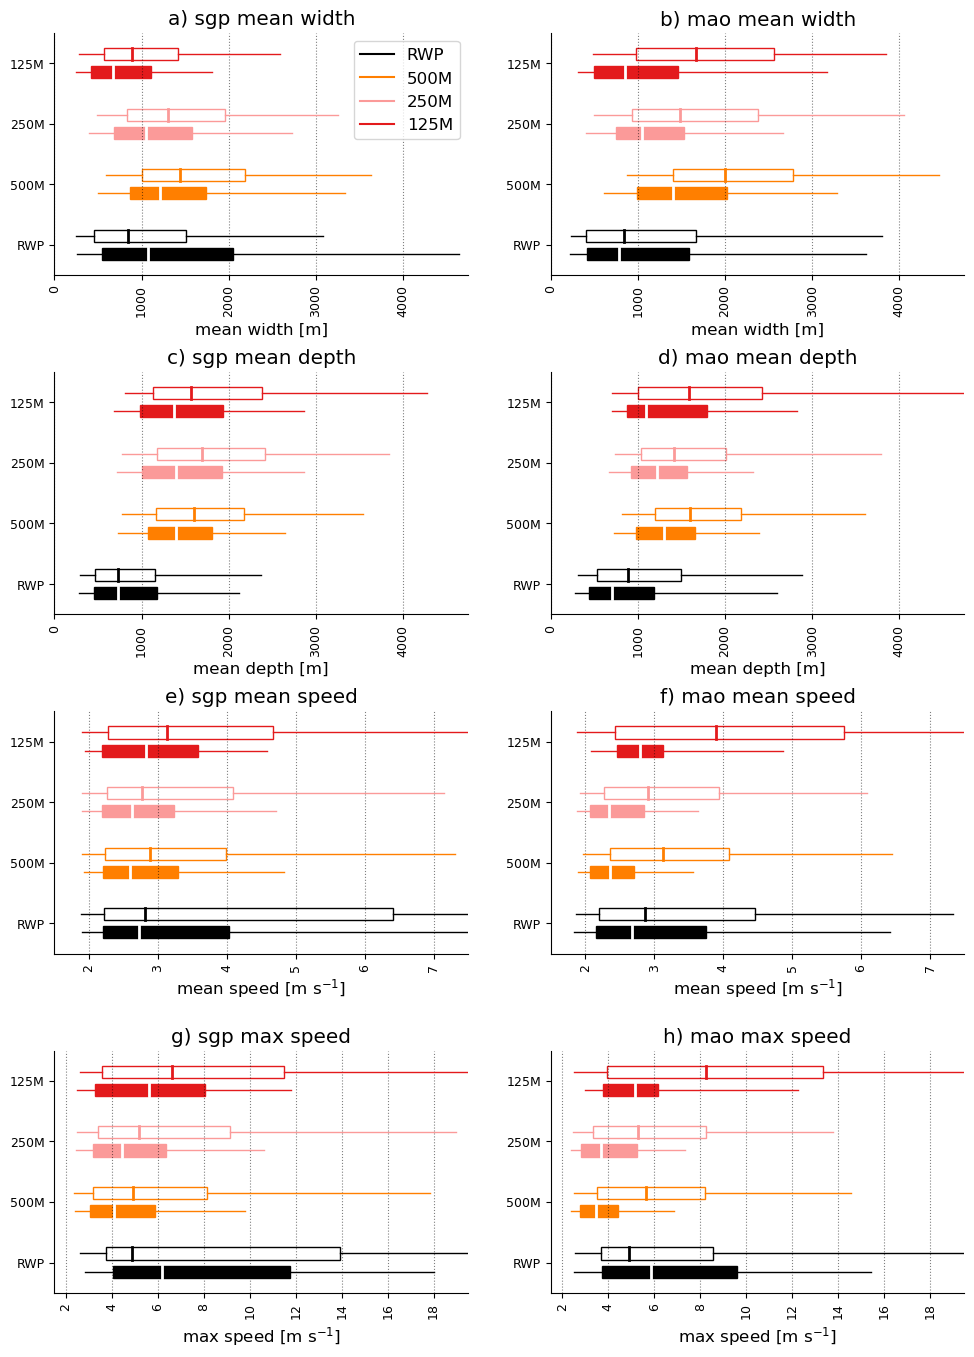

In [8]:
import matplotlib.patches as patches
from matplotlib.ticker import FormatStrFormatter

import string
abc_list = list(string.ascii_lowercase)

def bw_plot(data,
           ystart,
           color,
           up_down):
    percentiles = np.nanpercentile(data, (0,5,25,50,75,95,100))

    if up_down == 'down':
        y_width = 0.2
    else:
        y_width = -0.2
    yy = [ystart,ystart+y_width]
    # box
    if up_down == 'down':
        rect = patches.Rectangle((percentiles[2], yy[0]), percentiles[4] - percentiles[2], y_width, 
                          linewidth=1, edgecolor=color, facecolor=color)
    else:
        rect = patches.Rectangle((percentiles[2], yy[0]), percentiles[4] - percentiles[2], y_width, 
                          linewidth=1, edgecolor=color, facecolor='w')
    ax.add_patch(rect)
        
    # rect = patches.Rectangle((percentiles[2], yy[1]), percentiles[4] - percentiles[2], 0.25, 
    #                       linewidth=1, edgecolor=color, facecolor='none')
    # ax.add_patch(rect)

    # median
    if up_down == 'down':
        plt.plot([percentiles[3], percentiles[3]], [yy[1], yy[0]], c='w', lw=2)
    else:
        plt.plot([percentiles[3], percentiles[3]], [yy[1], yy[0]], c=color, lw=2)
    # plt.plot([percentiles[3], percentiles[3]], [yy[1], yy[1]+0.25], c=color, lw=0.5)
    # whiskers
    plt.plot([percentiles[1], percentiles[2]], [ystart+y_width/2, ystart+y_width/2], c=color, lw=1)
    plt.plot([percentiles[4], percentiles[5]], [ystart+y_width/2, ystart+y_width/2], c=color, lw=1)
    
    # # plot scatter plot of random sample
    # sampl = np.random.uniform(low=0, high=len(data), size=(100,)).astype(int)
    # rand_data = np.array(data)[sampl]
    # if up_down == 'down':
    #     plt.scatter(rand_data, np.linspace(yy[1]+0.025, yy[1]+ 0.2, 100), s=10, alpha=0.5, 
    #                 c=color, edgecolors='none')
    # else:
    #     plt.scatter(rand_data, np.linspace(yy[1]-0.025, yy[1]- 0.2, 100), s=10, alpha=0.5, 
    #                 c='none', edgecolors=color)



mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update({'font.size': 12})

stat_foc = ['mean width','mean depth','mean speed','max speed']
units = ['m','m','m s$^{-1}$', 'm s$^{-1}$']


fig = plt.figure(figsize=(10,15))
# Histogram plots
gs1 = gridspec.GridSpec(len(stat_foc),2) #rgiSize[2])
gs1.update(left=0.06, right=0.97,
           bottom=0.13, top=0.97,
           wspace=0.20, hspace=0.40)

speed_foc = '1.5'
co_type = 'vp'

for st in range(len(stat_foc)):
    stat = stat_foc[st]
    for lo in range(len(location)):
        ax = plt.subplot(gs1[st,lo])
        loc_act = location[lo]

        for di in range(len(up_down)):
            direction = up_down[di]

            if stat == 'mean elevation':
                newBins = np.arange(0,20000,500)
            elif stat == 'mean width':
                newBins = np.arange(0,5000,250)
            elif stat == 'mean depth':
                newBins = np.arange(0,5000,250)
            elif stat == 'mean speed':
                newBins = np.arange(1.5,8,1)
            elif stat == 'max speed':
                newBins = np.arange(1.5,20,1)
            elif stat == 'slope from vertical':
                newBins = np.arange(-3,3.1,0.1)

            key_name = direction+'_'+stat+'_'+speed_foc
            if loc_act == 'sgp':
                mean_width_rwp = sgp_stats[key_name]
            else:
                mean_width_rwp = mao_stats[key_name] 
            # plot half of a boxplot
            bw_plot(mean_width_rwp,
                   0.75-0.5*di,
                   'k',
                   direction)
            if di == 0:
                plt.plot([],[],color = 'k', label = 'RWP')
            del mean_width_rwp

            sel_dx = [3,4,5]
            for dx in range(len(sel_dx)):
                # try:
                if loc_act == 'sgp':
                    sim_stat = sgp_stats_vp[co_type+'_'+direction+'_'+stat+'_'+speed_foc+'_'+DX_all[sel_dx[dx]]]
                else:
                    sim_stat = mao_stats_vp[co_type+'_'+direction+'_'+stat+'_'+speed_foc+'_'+DX_all[sel_dx[dx]]]
                if len(sim_stat) > 0:
                    if type(sim_stat[0]) == np.ndarray:
                        sim_stat = list([x  for sublist in sim_stat for x in sublist])
                if len(np.unique(sim_stat)) == 1:
                    continue

                if len(sim_stat) > 100000:
                    sim_stat = sim_stat[::20]
                if len(sim_stat) > 1000000:
                    sim_stat = sim_stat[::200]

                bw_plot(sim_stat,
                       1*(dx+2)-0.5*di-0.25,
                       colors[sel_dx[dx]],
                       direction)
                if di == 0:
                    plt.plot([],[],color = colors[sel_dx[dx]], label = DX_all[sel_dx[dx]])
                # sns.distplot(sim_stat, color=colors[dx], bins=newBins, kde=True, hist=False, fit=None, \
                #              kde_kws={'clip': (newBins[0], newBins[-1]), 'linewidth':1, 'bw':0.2}, label=DX_all[dx])
                del sim_stat
                # except:
                #     continue

        ax.spines[['right', 'top']].set_visible(False)
        # ax.set_xscale('log')
        plt.grid(which='major', color='k', linestyle=':', axis='x', alpha = 0.5)
        plt.grid(which='minor', color='k', linestyle=':', axis='x', alpha = 0.5)
        plt.tick_params(axis='x', which='minor')
        ax.xaxis.set_minor_formatter(FormatStrFormatter("%.0f"))
        ax.tick_params(axis='both', which='both', labelsize=9)
        plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

        plt.xlabel(stat+' ['+units[st]+']')
        if (st == 0) & (lo == 0):
            plt.legend()

        plt.xlim(newBins[0], newBins[-1])
        plt.ylim(0, 4)
        
        ax.set_yticks([0.5,1.5,2.5,3.5])
        ax.set_yticklabels(['RWP','500M', '250M', '125M'])
            
        plt.title(abc_list[st*2 + lo]+') '+location[lo]+ ' ' + stat)
        
    
sPlotFile=''
sPlotName= 'Core-statistics_Box-Whisker_up-and-down.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)

plt.show()

### Plot median core statistics

mkdir: cannot create directory ‘’: No such file or directory


        Plot map to: Core-statistics_Convergence_up.pdf


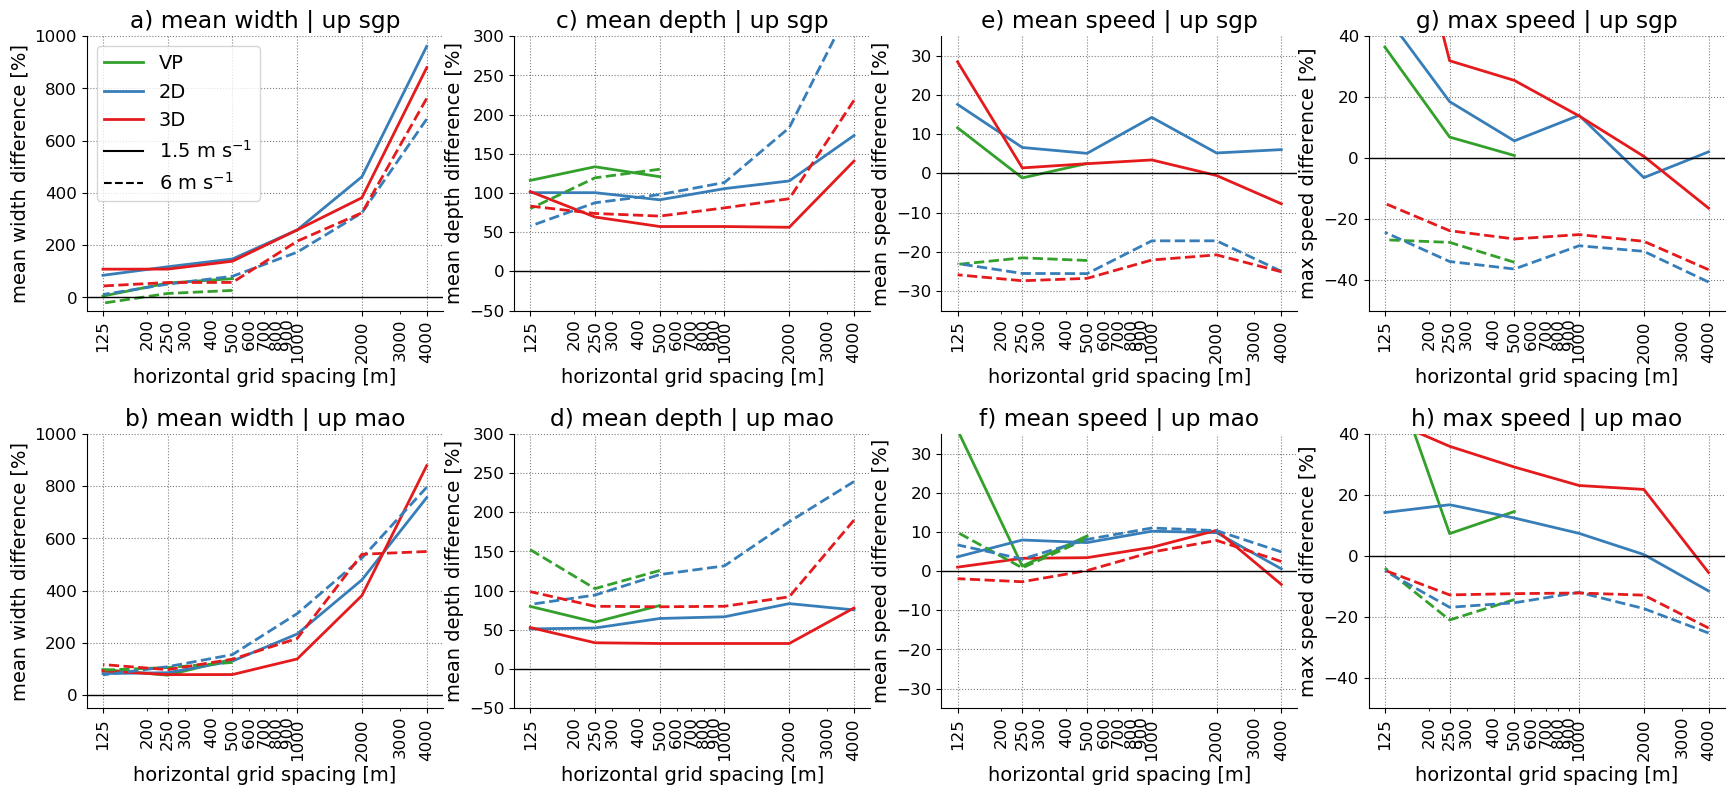

mkdir: cannot create directory ‘’: No such file or directory


        Plot map to: Core-statistics_Convergence_down.pdf


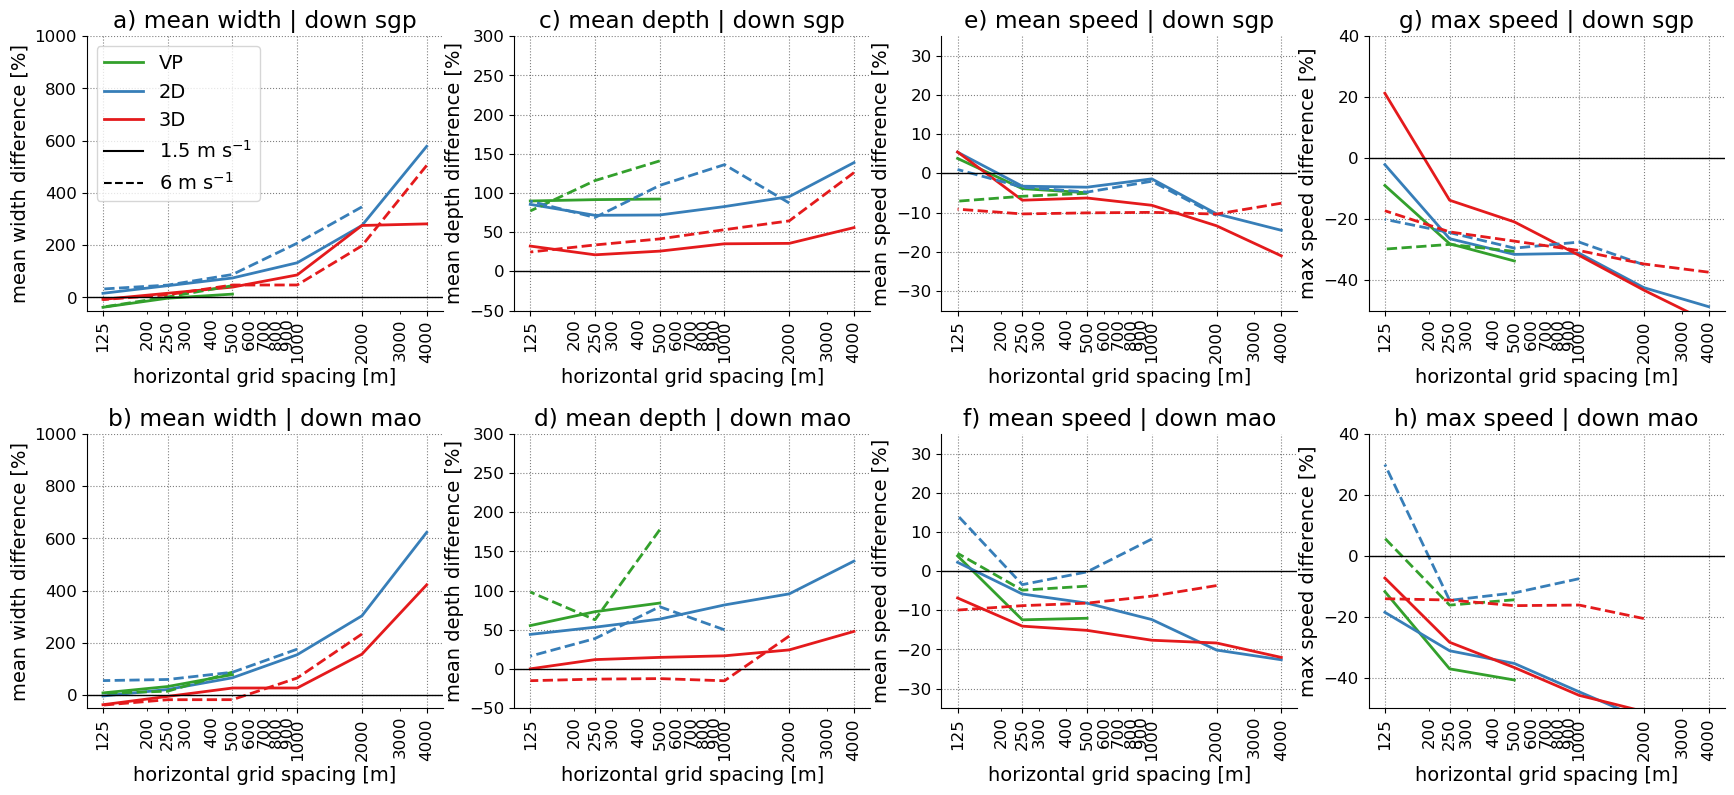

In [9]:

stats = ['mean width','mean depth','mean speed','max speed'] #['mean elevation', 'mean depth', 'max depth', 'mean speed', 'max speed', 'mean width', 'max width', 'slope from vertical']
units = ['m','m','m s$^{-1}$', 'm s$^{-1}$']
yrange = [[-50,1000], [-50,300], [-35,35], [-50,40]]
plt.rcParams.update({'font.size': 14})

for di in range(len(up_down)):
    
    fig = plt.figure(figsize=(18,8))
    # Histogram plots
    gs1 = gridspec.GridSpec(2,len(stat_foc)) #rgiSize[2])
    gs1.update(left=0.06, right=0.97,
               bottom=0.13, top=0.97,
               wspace=0.20, hspace=0.45)

    lnestyle = ['-','--']
    sped_sel = [0,2]
    for st in range(len(stats)):
        for lo in range(len(location)):
            ax = plt.subplot(gs1[lo,st])
            for sp in range(len(sped_sel)):

                obs_stat = core_stats[-1,di,0,
                                           speed.index(speed[sped_sel[sp]]),
                                           statistics.index(stats[st]),
                                           location.index(location[lo]),
                                           50]

                plt.plot(np.array(dx_km) * 1000, ((core_stats[:-1,di,
                                           core_type.index('vp'),
                                           speed.index(speed[sped_sel[sp]]),
                                           statistics.index(stats[st]),
                                           location.index(location[lo]),
                                           50] - obs_stat)/obs_stat)*100, 
                         c=color_cortype[2], label = 'VP',
                        ls = lnestyle[sp], lw=2)
                plt.plot(np.array(dx_km) * 1000, ((core_stats[:-1,di,
                                           core_type.index('2d'),
                                           speed.index(speed[sped_sel[sp]]),
                                           statistics.index(stats[st]),
                                           location.index(location[lo]),
                                           50] - obs_stat)/obs_stat)*100, 
                         c=color_cortype[1], label = '2D',
                        ls = lnestyle[sp], lw=2)
                plt.plot(np.array(dx_km) * 1000, ((core_stats[:-1,di,
                                           core_type.index('3d'),
                                           speed.index(speed[sped_sel[sp]]),
                                           statistics.index(stats[st]),
                                           location.index(location[lo]),
                                           50] - obs_stat)/obs_stat)*100, 
                         c=color_cortype[0], label = '3D',
                        ls = lnestyle[sp], lw=2)

                if (st == 0) & (sp == 0) & (lo == 0):
                    plt.plot([],[],ls='-',c='k',label = '1.5 m s$^{-1}$')
                    plt.plot([],[],ls='--',c='k',label = '6 m s$^{-1}$')
                    plt.legend()


                # plt.axhline(y=core_stats[-1,0,0,
                #                            speed.index(speed[sp]),
                #                            statistics.index(stats[st]),
                #                            location.index(location[lo]),
                #                            50], color='k',
                #         alpha = alpha[sp])

            plt.axhline(y=0, color='k', linestyle='-', lw=1)

            plt.xscale('log')    
            ax.spines[['right', 'top']].set_visible(False)
            plt.grid(which='major', color='k', linestyle=':', alpha = 0.5)
            # plt.grid(b=True, which='minor', color='k', linestyle=':', axis='x', alpha = 0.5)
            # plt.tick_params(axis='x', which='minor')
            ax.xaxis.set_minor_formatter(FormatStrFormatter("%.0f"))
            ax.tick_params(axis='both', which='both', labelsize=12)
            plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

            plt.xlabel('horizontal grid spacing [m]')
            plt.ylabel(stats[st]+' difference [%]')

            # plt.xlim(125, 4000)
            plt.ylim(yrange[st][0], yrange[st][1])


            ax.set_xticks([125,250,500,1000,2000,4000])
            ax.set_xticklabels(['125','250', '500', '1000', '2000', '4000'])


            plt.title(abc_list[st*2 + lo]+') '+stats[st]+' | '+up_down[di]+' '+ location[lo])


    sPlotFile=''
    sPlotName= 'Core-statistics_Convergence_'+up_down[di]+'.pdf'
    if os.path.isdir(sPlotFile) != 1:
        subprocess.call(["mkdir","-p",sPlotFile])
    print( '        Plot map to: '+sPlotFile+sPlotName)
    fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)

    plt.show()

# Plot conditional analysis

In [10]:
# work on the statistics

core_width_bins = np.arange(0,16,1)*1000
core_width_binsc = (core_width_bins[1:] + core_width_bins[:-1])/2
core_height_bins = np.arange(0,17,1)*1000
core_height_binsc = (core_height_bins[1:] + core_height_bins[:-1])/2

stats_foc = ['mean speed','max speed', 'mean/max'] #['mean elevation', 'mean depth', 'max depth', 'mean speed', 'max speed', 'mean width', 'max width', 'slope from vertical']
stats_foc_unit = ['m s$^{-1}$','m s$^{-1}$','']
stat_type = ['Q25','median', 'Q75', 'count']
perc = (25,50,75)

width_stats = np.zeros((len(core_width_binsc), len(stats_foc), len(DX_all)+1, len(up_down), len(core_type), len(speed), len(location), len(stat_type))); width_stats[:] = np.nan
depth_stats = np.zeros((len(core_height_binsc), len(stats_foc), len(DX_all)+1, len(up_down), len(core_type), len(speed), len(location), len(stat_type))); depth_stats[:] = np.nan

for dx in tqdm(range(len(DX_all))):
    for di in range(len(up_down)):
        for sp in range(len(speed)):
            for lo in range(len(location)):
                direction = up_down[di]
                dx_act = DX_all[dx]
                speed_foc = speed[sp]
                if dx_act != 'obs':
                    for ty in range(len(core_type)):
                        co_type = core_type[ty]
                        # read in core mean width
                        try:
                            if location[lo] == 'sgp':
                                sim_stat_width = sgp_stats_vp[co_type+'_'+direction+'_mean width_'+speed_foc+'_'+dx_act]
                            else:
                                sim_stat_width = mao_stats_vp[co_type+'_'+direction+'_mean width_'+speed_foc+'_'+dx_act]
                            if len(sim_stat_width) > 0:
                                if type(sim_stat_width[0]) == np.ndarray:
                                    sim_stat_width = list([np.mean(sim_stat_width[ii]) for ii in range(len(sim_stat_width))])
                                    # sim_stat_width = list([x  for sublist in sim_stat_width for x in sublist])
                            sim_stat_width = np.array(sim_stat_width)
                        except:
                            continue

                        # read in core mean speed
                        try:
                            if location[lo] == 'sgp':
                                sim_stat_meanspeed = sgp_stats_vp[co_type+'_'+direction+'_mean speed_'+speed_foc+'_'+dx_act]
                            else:
                                sim_stat_meanspeed = mao_stats_vp[co_type+'_'+direction+'_mean speed_'+speed_foc+'_'+dx_act]
                            if len(sim_stat_meanspeed) > 0:
                                if type(sim_stat_meanspeed[0]) == np.ndarray:
                                    sim_stat_meanspeed = list([x  for sublist in sim_stat_meanspeed for x in sublist])
                            sim_stat_meanspeed = np.array(sim_stat_meanspeed)
                        except:
                            continue

                        # read in core max speed
                        try:
                            if location[lo] == 'sgp':
                                sim_stat_maxspeed = sgp_stats_vp[co_type+'_'+direction+'_max speed_'+speed_foc+'_'+dx_act]
                            else:
                                sim_stat_maxspeed = mao_stats_vp[co_type+'_'+direction+'_max speed_'+speed_foc+'_'+dx_act]
                            if len(sim_stat_maxspeed) > 0:
                                if type(sim_stat_maxspeed[0]) == np.ndarray:
                                    sim_stat_maxspeed = list([x  for sublist in sim_stat_maxspeed for x in sublist])
                            sim_stat_maxspeed = np.array(sim_stat_maxspeed)
                        except:
                            continue

                        for bi in range(len(core_width_binsc)):
                            sel = (sim_stat_width >= core_width_bins[bi]) & (sim_stat_width < core_width_bins[bi+1])
                            sel_nr = np.sum(sel)
                            if sel_nr > 10:
                                width_stats[bi,stats_foc.index('mean speed'),dx,di,ty,sp,lo,-1] = sel_nr
                                if (ty == 0) & (dx == 0):
                                    stop()
                                for pp in range(len(perc)):
                                    width_stats[bi,stats_foc.index('mean speed'),dx,di,ty,sp,lo,pp] = \
                                        np.percentile(sim_stat_meanspeed[sel], perc[pp])

                                width_stats[bi,stats_foc.index('max speed'),dx,di,ty,sp,lo,-1] = sel_nr
                                for pp in range(len(perc)):
                                    width_stats[bi,stats_foc.index('max speed'),dx,di,ty,sp,lo,pp] = \
                                        np.percentile(sim_stat_maxspeed[sel], perc[pp])

                                width_stats[bi,stats_foc.index('mean/max'),dx,di,ty,sp,lo,-1] = sel_nr
                                frac = sim_stat_meanspeed[sel]/sim_stat_maxspeed[sel]
                                for pp in range(len(perc)):
                                    width_stats[bi,stats_foc.index('mean/max'),dx,di,ty,sp,lo,pp] = \
                                        np.percentile(frac, perc[pp])

                        del sim_stat_meanspeed, sim_stat_maxspeed, sim_stat_width
                else:
                    ty = 0
                    # work on observations
                    try:
                        if location[lo] == 'sgp':
                            sim_stat_width = sgp_stats[direction+'_mean width_'+speed_foc]
                        else:
                            sim_stat_width = mao_stats[direction+'_mean width_'+speed_foc]
                        if len(sim_stat_width) > 0:
                            if type(sim_stat_width[0]) == np.ndarray:
                                sim_stat_width = list([np.mean(sim_stat_width[ii]) for ii in range(len(sim_stat_width))])
                                # sim_stat_width = list([x  for sublist in sim_stat_width for x in sublist])
                        sim_stat_width = np.array(sim_stat_width)
                    except:
                        continue

                    # read in core mean speed
                    try:
                        if location[lo] == 'sgp':
                            sim_stat_meanspeed = sgp_stats[direction+'_mean speed_'+speed_foc]
                        else:
                            sim_stat_meanspeed = mao_stats[direction+'_mean speed_'+speed_foc]
                        if len(sim_stat_meanspeed) > 0:
                            if type(sim_stat_meanspeed[0]) == np.ndarray:
                                sim_stat_meanspeed = list([x  for sublist in sim_stat_meanspeed for x in sublist])
                        sim_stat_meanspeed = np.array(sim_stat_meanspeed)
                    except:
                        continue

                    # read in core max speed
                    try:
                        if location[lo] == 'sgp':
                            sim_stat_maxspeed = sgp_stats[direction+'_max speed_'+speed_foc]
                        else:
                            sim_stat_maxspeed = mao_stats[direction+'_max speed_'+speed_foc]
                        if len(sim_stat_maxspeed) > 0:
                            if type(sim_stat_maxspeed[0]) == np.ndarray:
                                sim_stat_maxspeed = list([x  for sublist in sim_stat_maxspeed for x in sublist])
                        sim_stat_maxspeed = np.array(sim_stat_maxspeed)
                    except:
                        continue
                    for bi in range(len(core_width_binsc)):
                        sel = (sim_stat_width >= core_width_bins[bi]) & (sim_stat_width < core_width_bins[bi+1])
                        sel_nr = np.sum(sel)
                        if sel_nr > 10:
                            width_stats[bi,stats_foc.index('mean speed'),dx,di,ty,sp,lo,-1] = sel_nr
                            for pp in range(len(perc)):
                                width_stats[bi,stats_foc.index('mean speed'),dx,di,ty,sp,lo,pp] = \
                                    np.percentile(sim_stat_meanspeed[sel], perc[pp])
                            width_stats[bi,stats_foc.index('max speed'),dx,di,ty,sp,lo,-1] = sel_nr
                            for pp in range(len(perc)):
                                width_stats[bi,stats_foc.index('max speed'),dx,di,ty,sp,lo,pp] = \
                                    np.percentile(sim_stat_maxspeed[sel], perc[pp])

                            width_stats[bi,stats_foc.index('mean/max'),dx,di,ty,sp,lo,-1] = sel_nr
                            frac = sim_stat_meanspeed[sel]/sim_stat_maxspeed[sel]
                            for pp in range(len(perc)):
                                width_stats[bi,stats_foc.index('mean/max'),dx,di,ty,sp,lo,pp] = \
                                    np.percentile(frac, perc[pp])

                    del sim_stat_meanspeed, sim_stat_maxspeed, sim_stat_width

100%|██████████| 7/7 [00:07<00:00,  1.12s/it]


mkdir: cannot create directory ‘’: No such file or directory


        Plot map to: Core-conditional-statistics_obs_up.pdf


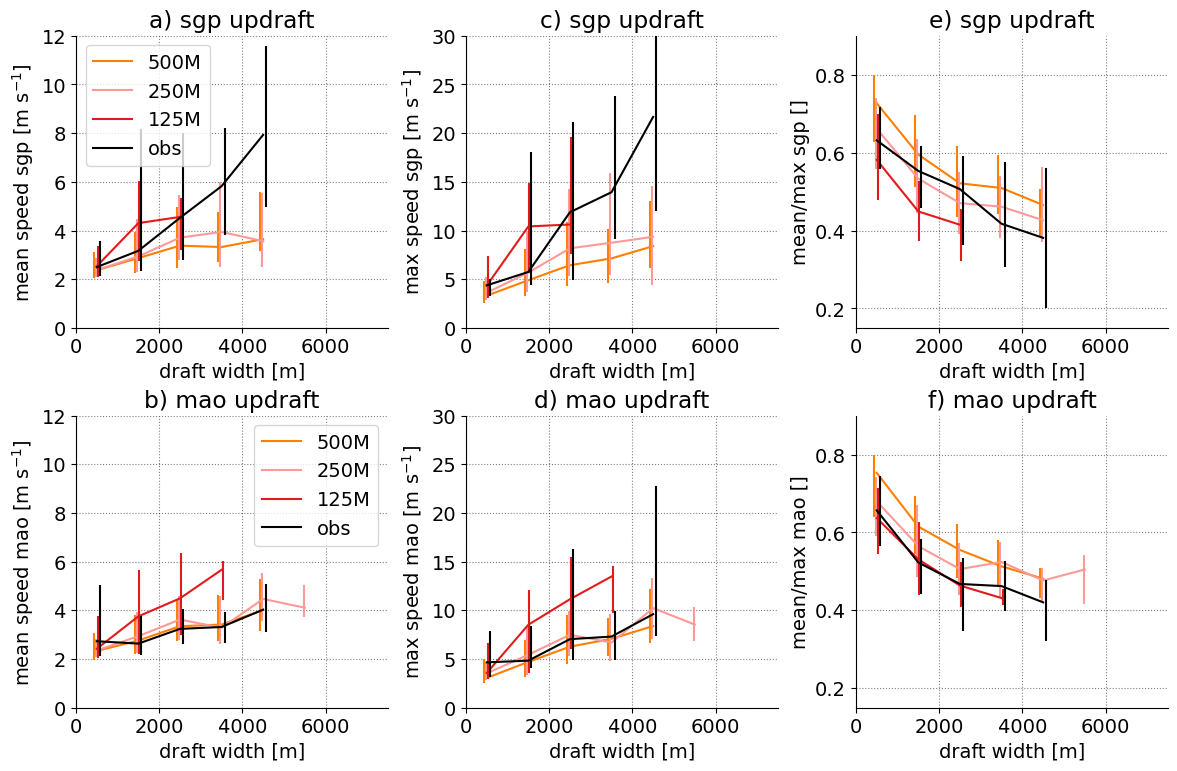

mkdir: cannot create directory ‘’: No such file or directory


        Plot map to: Core-conditional-statistics_obs_down.pdf


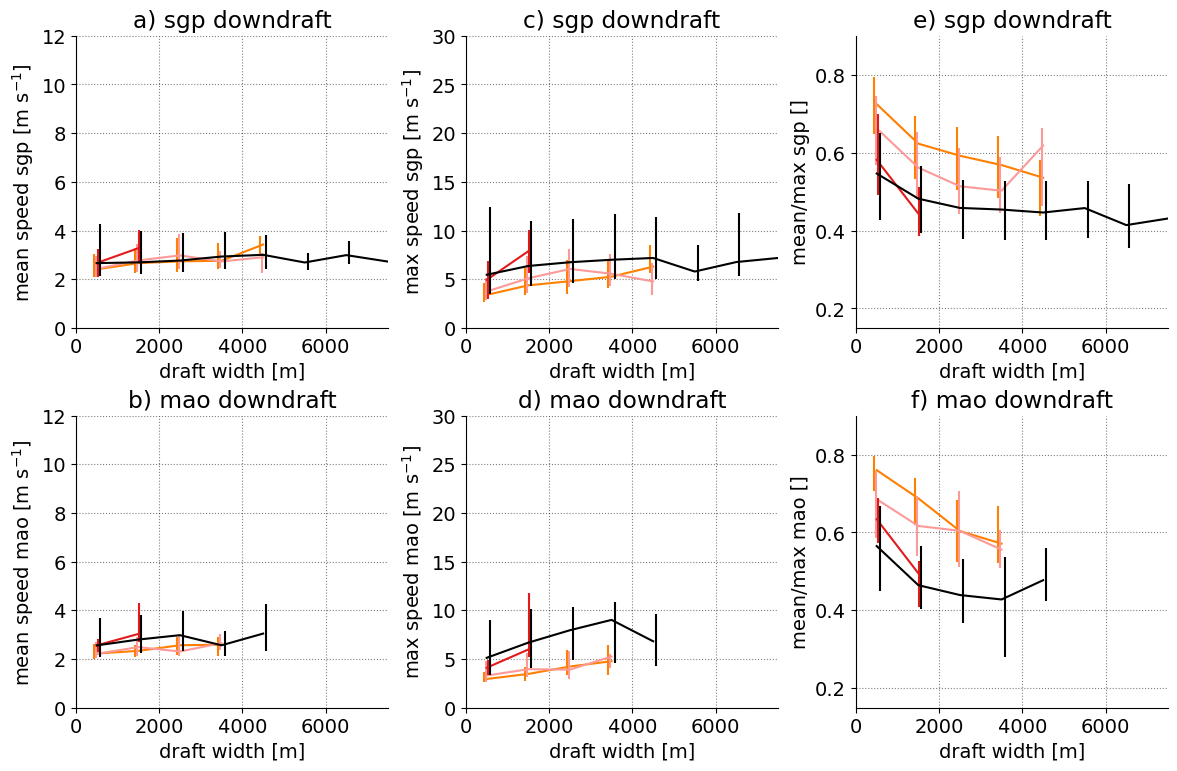

In [11]:
### Plot evaluation

ty = 0
sp = 0

for di in range(len(up_down)):
    fig = plt.figure(figsize=(12,8))
    # Histogram plots
    gs1 = gridspec.GridSpec(2,len(stats_foc)) #rgiSize[2])
    gs1.update(left=0.06, right=0.97,
               bottom=0.13, top=0.97,
               wspace=0.25, hspace=0.3)

    sel_dx = [3,4,5,6]
    y_displace = [-75,-25,25,75]
    y_range = [[0,12], [0,30], [0.15,0.9]]
    draft_name = ['updraft', 'downdraft']

    for st in range(len(stats_foc)):
        for lo in range(len(location)):
            ax = plt.subplot(gs1[lo,st])

            for dx in range(len(sel_dx)):
                y_val = width_stats[:,stats_foc.index(stats_foc[st]),sel_dx[dx],di,ty,sp,lo,1]
                plt.plot(core_width_binsc, y_val,
                        color = colors[sel_dx[dx]], label = DX_all[sel_dx[dx]]) 

                plt.errorbar(core_width_binsc + y_displace[dx], 
                             y_val,
                             yerr = (np.abs(y_val-width_stats[:,stats_foc.index(stats_foc[st]),sel_dx[dx],di,ty,sp,lo,0]),
                                     np.abs(width_stats[:,stats_foc.index(stats_foc[st]),sel_dx[dx],di,ty,sp,lo,2]-y_val)), 
                             fmt='none', color = colors[sel_dx[dx]])

                # bi,stats_foc.index('mean/max'),dx,di,ty,sp,lo,pp
            if (st == 0) & (di == 0):
                plt.legend()
            plt.xlim(0,7500)
            plt.ylim(y_range[st][0], y_range[st][1])
            ax.spines[['right', 'top']].set_visible(False)
            plt.grid(which='major', color='k', linestyle=':', alpha = 0.5)

            plt.xlabel('draft width [m]')
            plt.ylabel(stats_foc[st]+' '+location[lo]+' ['+stats_foc_unit[st]+']')

            plt.title(abc_list[st*2 +lo]+') ' +location[lo]+ ' ' + draft_name[di])


    sPlotFile=''
    sPlotName= 'Core-conditional-statistics_obs_'+up_down[di]+'.pdf'
    if os.path.isdir(sPlotFile) != 1:
        subprocess.call(["mkdir","-p",sPlotFile])
    print( '        Plot map to: '+sPlotFile+sPlotName)
    fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)

    plt.show()

mkdir: cannot create directory ‘’: No such file or directory


        Plot map to: Core-conditional-statistics_mod-3Dcores_up.pdf


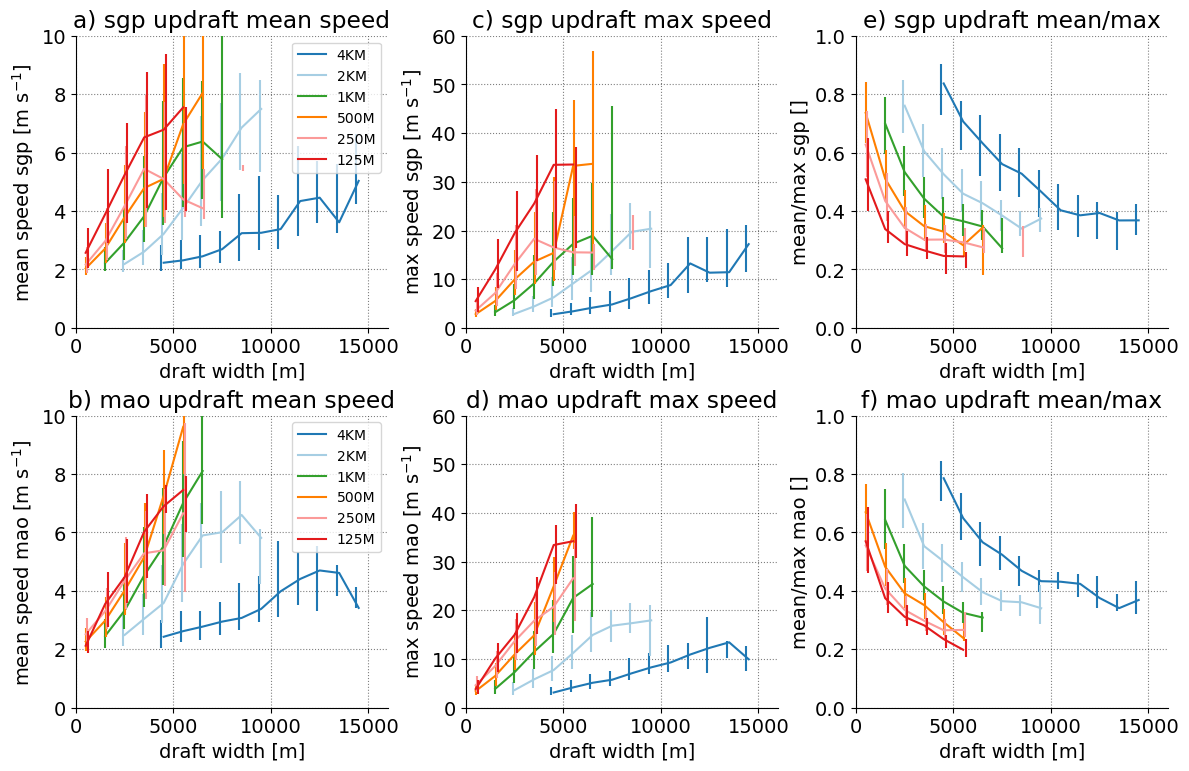

mkdir: cannot create directory ‘’: No such file or directory


        Plot map to: Core-conditional-statistics_mod-3Dcores_down.pdf


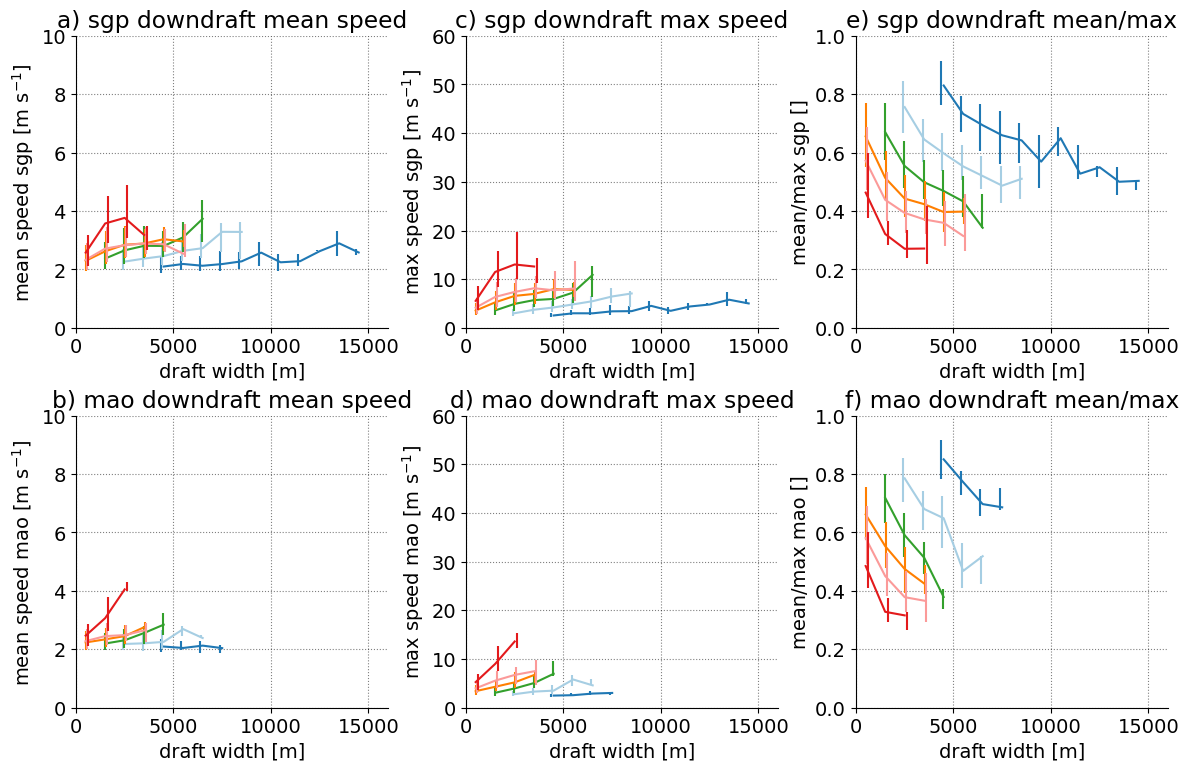

In [12]:
### Plot evaluation

ty = 2
sp = 0

for di in range(len(up_down)):
    fig = plt.figure(figsize=(12,8))
    # Histogram plots
    gs1 = gridspec.GridSpec(2,len(stats_foc)) #rgiSize[2])
    gs1.update(left=0.06, right=0.97,
               bottom=0.13, top=0.97,
               wspace=0.25, hspace=0.3)

    sel_dx = [0,1,2,3,4,5]
    y_displace = [-125,-75,-25,25,75,125]
    y_range = [[0,10], [0,60], [0,1]]
    draft_name = ['updraft', 'downdraft']

    for st in range(len(stats_foc)):
        for lo in range(len(location)):
            ax = plt.subplot(gs1[lo,st])

            for dx in range(len(sel_dx)):
                y_val = width_stats[:,stats_foc.index(stats_foc[st]),sel_dx[dx],di,ty,sp,lo,1]
                plt.plot(core_width_binsc, y_val,
                        color = colors[sel_dx[dx]], label = DX_all[sel_dx[dx]]) 

                plt.errorbar(core_width_binsc + y_displace[dx], 
                             y_val,
                             yerr = (np.abs(y_val-width_stats[:,stats_foc.index(stats_foc[st]),sel_dx[dx],di,ty,sp,lo,0]),
                                     np.abs(width_stats[:,stats_foc.index(stats_foc[st]),sel_dx[dx],di,ty,sp,lo,2]-y_val)), 
                             fmt='none', color = colors[sel_dx[dx]])

                # bi,stats_foc.index('mean/max'),dx,di,ty,sp,lo,pp
            if (st == 0) & (di == 0):
                plt.legend(prop={'size': 10})
            plt.xlim(0,16000)
            plt.ylim(y_range[st][0], y_range[st][1])
            ax.spines[['right', 'top']].set_visible(False)
            plt.grid(which='major', color='k', linestyle=':', alpha = 0.5)

            plt.xlabel('draft width [m]')
            plt.ylabel(stats_foc[st]+' '+location[lo]+' ['+stats_foc_unit[st]+']')

            plt.title(abc_list[st*2 +lo]+') ' +location[lo]+ ' ' + draft_name[di]+ ' '+stats_foc[st])


    sPlotFile=''
    sPlotName= 'Core-conditional-statistics_mod-3Dcores_'+up_down[di]+'.pdf'
    if os.path.isdir(sPlotFile) != 1:
        subprocess.call(["mkdir","-p",sPlotFile])
    print( '        Plot map to: '+sPlotFile+sPlotName)
    fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)

    plt.show()